In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.table import QTable
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

In [2]:
def calc_dmdt(eta, F_xuv, R_xuv, M_p):
    dmdt = (eta * np.pi * F_xuv * R_xuv**3)/(const.G * M_p)
    return dmdt

def calc_M(dmdt,dt):
    M = dmdt * dt
    return M

def calc_H(Rg, T, gs):
    H = Rg * T / gs
    return H

def calc_gs(m,r):
    g = const.G * m / r**2
    return g

def calc_ps(gs, Menv, dM, Rs):
    ps = gs * (Menv - dM) / (4 * np.pi * Rs**2)
    return ps

def calc_Rxuv(Rs, H, Pxuv, Ps):
    Rxuv = Rs**2 / (H * np.log(Pxuv/Ps) + Rs)
    return Rxuv

In [8]:
# reproduce figure 3
# 
alpha = 0.03
Mp = 2.5
Menv = alpha * Mp
Mcore = Mp - Menv

Mp = Mp * const.M_earth
Menv = Menv * const.M_earth
Mcore = Mcore * const.M_earth


#Rs = (Mcore.value/1.3)**(1/3.7) * u.m
Rs = 1.3 * (Mcore/u.kg) ** 0.27 *u.m # I dont think this is right? 

T = 880 * u.K
a = 0.1 * u.AU
Mstar = 1 * const.M_sun
Fxuv = 55 * u.W / (u.m**2)
eta = 0.1
Pxuv = 5 * u.Pa
Rg = 4124 * u.J / (u.kg * u.K) # stated as 4157 in paper, actually used 4124
tao = 1e8 * u.yr

Mp/const.M_earth, Menv/const.M_earth, Mcore/const.M_earth, Rs/const.R_earth




(<Quantity 2.5>,
 <Quantity 0.075>,
 <Quantity 2.425>,
 <Quantity 1.266826915619248>)

In [9]:
t = 0 * u.yr
dt = 10000 * u.yr
dM0 = 0 * u.kg

# constants
g = calc_gs(Mcore, Rs)
H = calc_H(Rg, T, g)

# intial conditions
P0 = calc_ps(g, Menv, dM0, Rs)
P0 = P0.to(u.Pa)
Rxuv0 = calc_Rxuv(Rs, H, Pxuv, P0)
Rxuv0 = Rxuv0.decompose()
if Rxuv0 <= Rs:
    Rxuv0 = Rs
dmdt0 = calc_dmdt(eta, Fxuv, Rxuv0, Mcore)
dmdt0 = dmdt0.decompose()

data = QTable()
# defining some initial conditions
data['time'] = [0]*u.yr
data['Mp'] = [Mp.decompose().value] * u.kg
data['alpha'] = [alpha]
data['Menv'] = [Menv.decompose().value] * u.kg
data['P_surf'] = [P0.decompose().value] * u.Pa
data['R_xuv'] = [Rxuv0.decompose().value] * u.m
data['dMdt'] = [dmdt0.decompose().value] * u.kg/u.s
data['dM'] = [(dmdt0 * dt).decompose().value] * u.kg
data

time,Mp,alpha,Menv,P_surf,R_xuv,dMdt,dM
yr,kg,,kg,Pa,m,kg / s,kg
float64,float64,float64,float64,float64,float64,float64,float64
0.0,1.49355e+25,0.03,4.48065e+23,8088243514.862843,22638372.719930742,207338947.13584083,6.543119558134011e+19


In [10]:

while data['time'][-1] < tao:
    #pdb.set_trace()
    t = data['time'][-1]
    t_new = t + dt

    Menv_new = data['Menv'][-1] - data['dM'][-1]
    Mp_new = Mcore+Menv_new
    alpha_new = Menv_new / Mp_new
    
    Ps_new = calc_ps(g, Menv_new, data['dM'][-1], Rs).decompose()
    Rxuv_new = calc_Rxuv(Rs, H, Pxuv, Ps_new).decompose()
    
    if Rxuv_new <= Rs:
        Rxuv_new = Rs
    if Ps_new <= 0:
        break
    dmdt_new = calc_dmdt(eta, Fxuv, Rxuv_new, Mcore).decompose()
    
    dm_new = (dmdt_new * dt).decompose()
    data.add_row((t_new, Mp_new, alpha_new, Menv_new, Ps_new, Rxuv_new, dmdt_new, dm_new))

    
    

/home/dm1681/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


In [11]:
data

time,Mp,alpha,Menv,P_surf,R_xuv,dMdt,dM
yr,kg,,kg,Pa,m,kg / s,kg
float64,float64,float64,float64,float64,float64,float64,float64
0.0,1.49355e+25,0.03,4.48065e+23,8088243514.862843,22638372.719930742,207338947.13584083,6.543119558134011e+19
10000.0,1.4935434568804418e+25,0.0299957504913,4.4799956880441863e+23,8085881252.944011,22637810.830414843,207323508.9207576,6.5426323651177e+19
20000.0,1.4935369142480765e+25,0.0299915012617,4.4793414248076746e+23,8084700297.87585,22637529.876406502,207315789.84645534,6.542388769658499e+19
30000.0,1.493530371859307e+25,0.0299872521531,4.478687185930709e+23,8083519342.807311,22637248.88833051,207308070.02779603,6.542145150709176e+19
40000.0,1.4935238297141563e+25,0.0299830031656,4.4780329714156376e+23,8082338431.719875,22636967.876644213,207300349.7521397,6.5419015173381235e+19
50000.0,1.493517287812639e+25,0.029978754299,4.477378781263904e+23,8081157564.614514,22636686.841342464,207292629.01939088,6.5416578695423295e+19
60000.0,1.4935107461547694e+25,0.0299745055535,4.4767246154769495e+23,8079976741.493825,22636405.782420482,207284907.82946414,6.541414207319097e+19
70000.0,1.493504204740562e+25,0.029970256929,4.4760704740562175e+23,8078795962.360418,22636124.699873492,207277186.1822743,6.54117053066574e+19


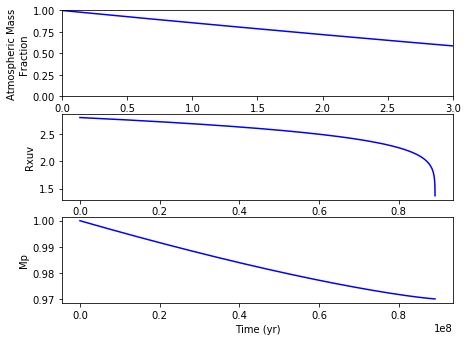

In [12]:
time = data['time']
Menv = data['Menv']
Mp = data['Mp']
Psurf = data['P_surf']
Rxuv = data['R_xuv']
dmdt = data['dMdt']
dm = data['dM']


fig,ax = plt.subplots(3,1)
fig.set_size_inches(7,7)
fig.subplots_adjust(bottom=0.3)

ax[0].plot(time, Menv/Menv[0], color='blue')
ax[0].set(ylabel='Atmospheric Mass\nFraction', xlim=(0,30e6), ylim=(0,1))

ax[1].plot(time, Rxuv/Rs, color='blue')
ax[1].set(ylabel='Rxuv')

ax[2].plot(time, Mp/Mp[0], color='blue')
ax[2].set(ylabel='Mp', xlabel='Time (yr)')


    

fig.savefig('atmesc.pdf')

In [ ]:
H

In [ ]:
lehm_final_time = 28644016 * u.yr
diego_final_time = data['time'][-1]
(diego_final_time - lehm_final_time)/(lehm_final_time)

In [ ]:
diego_final_time

In [ ]:
lehm_final_time

In [ ]:
data['dMdt'][0]

In [ ]:
c_data = QTable.read('/home/dm1681/vplanet/testing/lehmer17/atm.b.forward', format='ascii')
c_data.rename_column('col1','time(yr)')
c_data.rename_column('col2','Mass(earth)')
c_data.rename_column('col3','EnvMass(earth)')
c_data.rename_column('col4','Radius(sol)')
c_data.rename_column('col5','RadXUV(earth)')

In [ ]:
c_time = c_data['time(yr)']
c_Menv = c_data['EnvMass(earth)']
c_Rxuv = c_data['RadXUV(earth)']


fig,ax = plt.subplots(2,1)
fig.set_size_inches(7,7)
fig.subplots_adjust(bottom=0.3)

ax[0].plot(c_time, c_Menv/c_Menv[0], color='blue', label='vplanet')
ax[0].plot(time, Menv/Menv[0], color='orange', label='lehmer')
ax[0].set(ylabel='Atmospheric Mass\nFraction')

ax[1].plot(c_time, c_Rxuv/c_Rxuv[0], color='blue', label='vplanet')
ax[1].plot(time, Rxuv/Rxuv[0], color='orange', label='lehmer')
ax[1].set(ylabel='Rxuv Fraction', xlabel='Time(yr)')

ax[0].legend()

fig.savefig('2xvpl_vs_lehm.pdf')

In [ ]:
c_time[-1]/time[-1].value

In [ ]:
time[-1]

In [ ]:
(-1.0699361804488962e-14 * const.M_sun / u.yr).to(u.kg/u.s)